<a href="https://colab.research.google.com/github/tanakakao/studymemo/blob/main/vit2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

170498071/170498071 [==============================] - 13s 0us/step


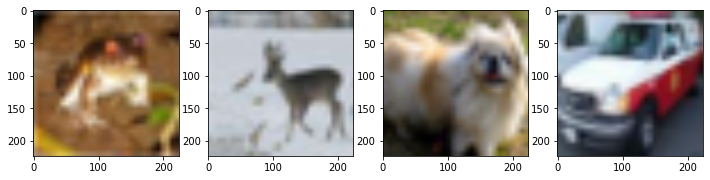

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Input, Dense, Conv1D, Conv2D, Activation, Dropout, LayerNormalization, Reshape, MultiHeadAttention, RepeatVector, Concatenate
from tensorflow.keras import activations
from tensorflow.keras.optimizers import RMSprop, Adagrad
from tensorflow.keras.callbacks import LearningRateScheduler
from keras import backend as K

import numpy as np
import pandas as pd
import math
import time

import matplotlib.pyplot as plt
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import cv2

# データセットの読み込み
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# バッチサイズ、クラス数、エポック数の設定
batch_size=32
num_classes=10
epochs=5

# データリサイズ
img_rows=224
img_cols=224

x_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_train[::20,:,:,:]])
x_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_test[::20,:,:,:]])

# データ正規化
x_train=x_train.astype('float32')
x_train/=255
x_test=x_test.astype('float32')
x_test/=255

# one-hotベクトル化
y_train = y_train[::20]
y_test = y_test[::20]
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

fig, axes = plt.subplots(1, 4, figsize=(12,3))
[axes[i].imshow(x_train[i]) for i in range(4)];

In [2]:
class patch_embbeding(Layer):
    def __init__(self, img_size, patch_size=4, hidden_dim=8, batch_size=None):
        super().__init__()
        self.D = hidden_dim
        if batch_size is not None:
            self.n = batch_size
        else:
            self.n = 1
        
        self.patch_conv = Conv2D(filters = hidden_dim, kernel_size = (patch_size,patch_size), strides=patch_size, padding = 'same')
        
        # [class]追加
        self._class = self.add_weight(
            shape=(1,hidden_dim), initializer="random_normal", trainable=True, name='class', dtype=tf.float32
        )
        
        # position encoding
        self.position = self.add_weight(
            shape=(int(img_size[0]*img_size[1]/(patch_size*patch_size))+1,1), initializer="random_normal", trainable=True, name='position', dtype=tf.float32
        )
        
        self.repeat = RepeatVector
        
    def call(self, inputs):
        out = self.patch_conv(inputs)
        out = Reshape((-1,self.D))(out)
        _class = Reshape((self.n,1,self.D))(RepeatVector(self.n)(self._class))[0]
        out = Concatenate(axis=1)([_class, out])
        out = out*self.position 
        return out

class MultiHeadAttention(Layer):
    '''
    Multi-Head Attentionレイヤ

    model = MultiheadAttention(
        hidden_dim = 512,
        head_num = 8,
        drop_rate = 0.5
    )
    '''
    def __init__(self, hidden_dim, heads_num, drop_rate=0.5):
        '''
        Multi-Head Attentionレイヤ
    
        hidden_dim : Embeddingされた単語ベクトルの長さ
        heads_num : マルチヘッドAttentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''

        super(MultiHeadAttention, self).__init__()
        # 入力の線形変換
        # 重み行列は[hidden_dim, hidden_dim]
        self.query = Conv1D(hidden_dim, kernel_size=1)
        self.key   = Conv1D(hidden_dim, kernel_size=1)
        self.value = Conv1D(hidden_dim, kernel_size=1)
        
        # 出力の線形変換
        self.projection = Conv1D(hidden_dim, kernel_size=1)
        
        # 出力のDropout
        self.drop = Dropout(drop_rate)
        
        self.nf = hidden_dim
        self.nh = heads_num
    
    def atten(self, query, key, value, attention_mask, training):
        """
        Attention
        
        query, key, value : クエリ、キー、バリュー
            query [batch_size, head_num, q_length, hidden_dim//head_num]
            key, value [batch_size, head_num, m_length, hidden_dim//head_num]
            ただし、encoder:q_length=m_length
                   decoder:mask multihead attentionではq_length=m_length
                           2つ目のmultihead attentionではq_length≠m_length
        attention_mask : attention weight に適用される mask
            encoder : [1, 1, q_length, q_length]
            decoder : [1, 1, m_length, m_length]
        """
        # 各値を取得
        shape = query.shape.as_list() # batch_size, head_num, q_length, hidden_dim//head_num
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[2] # トークン列数(q_length)
        hidden_dim = shape[1]*shape[3] # 特徴ベクトルの長さ(head_num × hidden_dim//head_num = hidden_dim)
        
        # ここで q と k の内積を取ることで、query と key の単語間の関連度のようなものを計算します。
        # tf.matmulで最後の2成分について積を計算(それ以外は形がそろっている必要あり)
        # transpose_bで転置
        # [batch_size, head_num, q_length, hidden_dim/head_num] @ [batch_size, head_num, hidden_dim/head_num, m_length] = [batch_size, head_num, q_length, m_length]
        scores = tf.matmul(query, key, transpose_b=True)
        
        # scoreをhidden_dimの平方根割る
        scores = tf.multiply(scores, tf.math.rsqrt(tf.cast(hidden_dim, tf.float32)))
        
        # Attention Maskがあればscoreに加算
        # attention_mask: [1, 1, (q|m)_length, (q|m)_length] 
        # マスク(参照しない部分)の場所に1、使用する部分は0とする
        # 1の部分を -無限大にする(softmax(-無限大)=0となる)
        # 1. PADを無視
        # 2. DecoderのSelf-Attentionで未来の情報を参照できないようにする
        if attention_mask is not None:
            scores = scores + attention_mask * -1e9
        # softmax を取ることで正規化します
        # input(query) の各単語に対して memory(key) の各単語のどこから情報を引いてくるかの重み
        atten_weight = tf.nn.softmax(scores, axis=-1)
        
        # 重みに従って value から情報を引いてきます
        # [batch_size, head_num, q_length, m_length] @ [batch_size, head_num, m_length, hidden_dim/head_num] = [batch_size, head_num, q_length, hidden_dim/head_num]
        # input(query) の単語ごとに memory(value)の各単語 に attention_weight を掛け合わせて足し合わせた ベクトル(分散表現の重み付き和)を計算
        context = tf.matmul(atten_weight, value)
        
        # 各ヘッドの結合(reshape)
        # 入力と同じ形に変換する
        # [batch_size, head_num, q_length, hidden_dim/head_num] -> [batch_size, q_length, head_num, hidden_dim/head_num]
        context = tf.transpose(context, [0, 2, 1, 3])
        # [batch_size, q_length, head_num, hidden_dim/head_num] -> [batch_size, q_length, hidden_dim]
        context = tf.reshape(context, (batch_size, token_num, hidden_dim))
        
        # 線形変換
        context = self.projection(context, training=training)
        
        return self.drop(context, training=training), atten_weight

    def _split(self, x):
        """
        query, key, valueを分割する
        
        入力 shape: [batch_size, length, hidden_dim]
        出力 shape: [batch_size, head_num, length, hidden_dim//head_num]
        """
        # 各値を取得
        hidden_dim = self.nf
        heads_num = self.nh
        shape = x.shape.as_list()
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[1] # トークン列数
        
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, (q|m)_length, head_num, hidden_dim/head_num]
        # splitだが実際は次元を拡張する処理
        x = tf.reshape(x, (batch_size, token_num, heads_num, int(hidden_dim/heads_num)))
        
        # [batch_size, (q|m)_length, head_num, hidden_dim/head_num] -> [batch_size, head_num, (q|m)_length, hidden_dim/head_num]
        x = tf.transpose(x, [0, 2, 1, 3])
        return x
    
    def call(self, x, training, memory, attention_mask=None, return_attention_scores=False):
        """
        モデルの実行
        
        input : 入力(query) [batch_size, length, hidden_dim]
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのtoken_numと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        """
        # memoryが入力されない場合、memory=input(Self Attention)とする
        if memory is None:
            memory = x

        # input -> query
        # memory -> key, value
        # [batch_size, (q|m)_length, hidden_dim] @ [hidden_dim, hidden_dim] -> [batch_size, (q|m)_length, hidden_dim] 
        query = self.query(x)
        key = self.key(memory)
        value = self.value(memory)
        
        # ヘッド数に分割する
        # 実際はreshapeで次数を1つ増やす
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, head_num, (q|m)_length, hidden_dim/head_num]
        query = self._split(query)
        key = self._split(key)
        value = self._split(value)
        
        # attention
        # 入力と同じ形の出力
        # context: [batch_size, q_length, hidden_dim]
        # score_weightsはEncoderではNoneとする
        context, attn_weights = self.atten(query, key, value, attention_mask, training)
        if not return_attention_scores:
            return context
        else:
            return context, attn_weights

class FeedForwardNetwork(Layer):
    '''
    Position-wise Feedforward Neural Network
    transformer blockで使用される全結合層
    '''
    def __init__(self, hidden_dim, drop_rate):
        '''
        hidden_dim : Embeddingされた単語ベクトルの長さ
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        # 2層構造
        # 1層目：チャンネル数を増加させる
        self.filter_dense_layer = Dense(hidden_dim * 4, use_bias=True, activation='gelu')
        
        # 2層目：元のチャンネル数に戻す
        self.output_dense_layer = Dense(hidden_dim, use_bias=True)
        self.drop = Dropout(drop_rate)

    def call(self, x, training):
        '''
        入力と出力で形が変わらない
        x : 入力 [batch_size, length, hidden_dim]
        '''
        
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, (q|m)_length, 4*hidden_dim]
        x = self.filter_dense_layer(x)
        x = self.drop(x, training=training)
        
        # [batch_size, (q|m)_length, 4*hidden_dim] -> [batch_size, (q|m)_length, hidden_dim]
        return self.output_dense_layer(x)

class ResidualNormalizationWrapper(Layer):
    '''
    残差接続
    output: input + SubLayer(input)
    '''
    def __init__(self, layer, drop_rate):
        '''
        layer : 残渣接続したいレイヤ(MultiHeadAttentionかFeedForwardNetwork)に適用
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.layer = layer # SubLayer : ここではAttentionかFFN
        self.layer_normalization = LayerNormalization()
        self.drop = Dropout(drop_rate)

    def call(self, x, training, memory=None, attention_mask=None, return_attention_scores=None):
        """
        モデルの実行
        
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのlengthと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, q_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか

        AttentionもFFNも入力と出力で形が変わらない
        output : [batch_size, length, hidden_dim]
        """
        
        params = {}
        if memory is not None:
            params['memory'] = memory
        if attention_mask is not None:
            params['attention_mask'] = attention_mask
        if return_attention_scores:
            params['return_attention_scores'] = return_attention_scores
        
        out = self.layer_normalization(x)
        if return_attention_scores:
            # attention weightを返す
            out, attn_weights = self.layer(out, training, **params)
            out = self.drop(out, training=training)
            return x + out, attn_weights
        else:
            # attention weightを返さない
            out = self.layer(out, training, **params)
            out = self.drop(out, training=training)
            return x + out

class EncoderLayer(Layer):
    """
    Encoderレイヤ
    　MultiHeadAttentionとFeedForwardNetworkの組み合わせ
      それぞれ残差接続されている
    """
    def __init__(self, hidden_dim, heads_num, drop_rate=0.2):
        """
        hidden_dim : Embeddingされた単語ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        """
        super().__init__()
        # Multi-head attention
        self.atten = ResidualNormalizationWrapper(
            layer = MultiHeadAttention(hidden_dim = hidden_dim,
                                       heads_num = heads_num,
                                       drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        # Feed Forward Network
        self.ffn = ResidualNormalizationWrapper(
            layer = FeedForwardNetwork(hidden_dim = hidden_dim,
                                       drop_rate = drop_rate),
            drop_rate = drop_rate)
    
    def call(self, input, training, memory, attention_mask=None, return_attention_scores=False):
        """
        x : 入力(query) [batch_size, length, hidden_dim]
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのtoken_numと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか

        AttentionもFFNも入力と出力で形が変わらない
        output : [batch_size, length, hidden_dim]
        
        入力と出力で形式が変わらない
        output : [batch_size, length, hidden_dim]
        """
        
        if return_attention_scores:
            x, attn_weights = self.atten(input,training, memory, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x, attn_weights
        else:
            x = self.atten(input, training, memory, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x

class Encoder(Layer):
    '''
    TransformerのEncoder
    '''
    def __init__(self, img_size, patch_size, hopping_num, heads_num, hidden_dim, drop_rate, batch_size=None):
        '''
        hopping_num : Multi-head Attentionの繰り返し数
        hidden_dim : Embeddingされた特徴ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.hopping_num = hopping_num
        
        # Position Embedding
        self.patch_embbeding = patch_embbeding(img_size=img_size, patch_size=patch_size, hidden_dim=hidden_dim, batch_size=batch_size)
        self.input_dropout_layer = Dropout(drop_rate)

        # Multi-head Attentionの繰り返し(hopping)のリスト
        self.attention_block_list = [EncoderLayer(hidden_dim, heads_num) for _ in range(hopping_num)]
        self.output_normalization = LayerNormalization()

    def call(self, input, training, attention_mask=None, return_attention_scores=False):
        '''
        input: 入力 [batch_size, q_length, hidden_dim]
        memory: 入力 [batch_size, m_length, hidden_dim]
        attention_mask: attention weight に適用される mask
            [batch_size, 1, q_length, q_length] 
            pad 等無視する部分が 0 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        出力 [batch_size, q_length, hidden_dim]
        '''
        # Positional Embedding
        embedded_input = self.patch_embbeding(input)
        query = self.input_dropout_layer(embedded_input, training=training)

        # Encoderレイヤを繰り返し適用
        if return_attention_scores:
            for i in range(self.hopping_num):
                query, atten_weights = self.attention_block_list[i](query, training, embedded_input, attention_mask, return_attention_scores)

            # [batch_size, q_length, hidden_dim]
            return self.output_normalization(query), atten_weights
        else:
            for i in range(self.hopping_num):
                query = self.attention_block_list[i](query, training, embedded_input, attention_mask, return_attention_scores)
                #print(query.shape)
            # [batch_size, q_length, hidden_dim]
            return self.output_normalization(query)

class VisionTransformer(Model):
    """
    Transformerベースの時系列予測モデル
    
    """
    def __init__(self, img_size, patch_size, hopping_num, heads_num, hidden_dim, drop_rate, batch_size=None):
        '''
        hopping_num : Multi-head Attentionの繰り返し数
        hidden_dim : Embeddingされた特徴ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.encoder = Encoder(img_size, patch_size, hopping_num, heads_num, hidden_dim, drop_rate, batch_size)
        
        # 全結合層
        self.fc1 = Dense(32)
        self.dropout1 = Dropout(drop_rate)
        self.fc2 = Dense(16)
        self.dropout2 = Dropout(drop_rate)
        self.layer_normalization = LayerNormalization()

        self.final_layer = Dense(10, activation='sigmoid')

    def call(self, inputs, return_attention_scores=False):
        '''
        inputs: 入力(encoder, decoder)
        return_attention_scores : attention weightを出力するか
        '''
        # Encoderの出力はDecoderへの入力(memory)となる
        # enc_input : [batch_size, enc_length, hidden_dim]
        if return_attention_scores:
            enc_output, enc_atten_weights = self.encoder(inputs, attention_mask=None,return_attention_scores=return_attention_scores)
        else:
            enc_output = self.encoder(inputs, attention_mask=None,return_attention_scores=return_attention_scores)
         
        # [batch_size, dec_length, hidden_dim] -> [batch_size, dec_length]
        class_output = enc_output[:,0,:]
        
        fc_output = self.fc1(class_output)
        fc_output = self.dropout1(fc_output)
        fc_output = self.layer_normalization(fc_output)
        fc_output = self.fc2(fc_output)
        fc_output = self.dropout2(fc_output)
        final_output = self.final_layer(fc_output)

        if return_attention_scores:
            return final_output, enc_atten_weights
        else:
            return final_output

In [16]:
batch_size=25
epochs = 300
initial_lrate = 0.001

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.99
    epochs_drop = 3
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = RMSprop(learning_rate=initial_lrate, rho=0.9, epsilon=1.0)

#lr_sc = LearningRateScheduler(decay, verbose=1)

model = VisionTransformer(img_size=(224,224), patch_size=8, hopping_num=4, heads_num=4, hidden_dim=64, drop_rate=0.1, batch_size=batch_size)
model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

In [7]:
len(x_test)

500

In [17]:
history=model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  steps_per_epoch=int(len(x_train)//batch_size),
                  validation_data=(x_test, y_test),
                  validation_steps=int(len(x_test)//batch_size))

Epoch 1/300
100/100 [==============================] - 35s 200ms/step - loss: 2.4600 - accuracy: 0.0992 - val_loss: 2.3189 - val_accuracy: 0.1020
Epoch 2/300
100/100 [==============================] - 19s 186ms/step - loss: 2.3324 - accuracy: 0.1148 - val_loss: 2.2207 - val_accuracy: 0.1780
Epoch 3/300
100/100 [==============================] - 19s 186ms/step - loss: 2.2261 - accuracy: 0.1752 - val_loss: 2.1242 - val_accuracy: 0.1960
Epoch 4/300
100/100 [==============================] - 19s 186ms/step - loss: 2.1503 - accuracy: 0.1916 - val_loss: 2.0447 - val_accuracy: 0.2400
Epoch 5/300
100/100 [==============================] - 19s 186ms/step - loss: 2.0972 - accuracy: 0.2136 - val_loss: 2.1049 - val_accuracy: 0.2160
Epoch 6/300
100/100 [==============================] - 19s 187ms/step - loss: 2.0798 - accuracy: 0.2028 - val_loss: 2.0071 - val_accuracy: 0.2540
Epoch 7/300
100/100 [==============================] - 19s 187ms/step - loss: 2.0430 - accuracy: 0.2336 - val_loss: 2.0079 -